In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
# 加载数据
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']



In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
from sklearn.metrics import confusion_matrix  # 混淆矩阵
from sklearn.model_selection import train_test_split  # 划分数据集
import math
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn import metrics  # 模型评估
from keras import Input
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Add, Multiply, \
    GlobalAveragePooling1D, Concatenate, AvgPool1D, BatchNormalization, ELU, Activation,  SeparableConv1D,Conv2D, Lambda,\
    Reshape,GlobalMaxPooling1D,GRU
from keras import backend as K
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras_flops import get_flops
D = 32
S = 16
C = D+S
r1 = 4
r2 = 2

def DC_Block1(input, k, c, padding='same'):

    conv1_1 = SeparableConv1D(c,kernel_size=k, strides=1, padding=padding)(input)
    conv1_1 = BatchNormalization(momentum=0.99, epsilon=0.001)(conv1_1)
    conv1_1 = ELU()(conv1_1)

    # conv1_1 = Conv1D(filters=c, kernel_size=1, strides=1)(conv1_1)
    # conv1_1 = BatchNormalization(momentum=0.99, epsilon=0.001)(conv1_1)
    # conv1_1 = ELU()(conv1_1)
    conv1_1 = MaxPooling1D(pool_size=2, strides=2)(conv1_1)

    return conv1_1

def Block1(input, k, c, padding='same'):

    conv1_1 = Conv1D(filters=c, kernel_size=k, strides=1, padding=padding)(input)
    conv1_1 = BatchNormalization(momentum=0.99, epsilon=0.001)(conv1_1)
    conv1_1 = ELU()(conv1_1)
    conv1_1 = MaxPooling1D(pool_size=2, strides=2)(conv1_1)
    return conv1_1

def senet(inputs, c, r):

    x = GlobalAveragePooling1D()(inputs)
    x = Dense(int(x.shape[-1]) // r, activation='relu')(x)
    x = Dense(c, activation='sigmoid')(x)
    return x

def models(input_shape):

    x0 = Conv1D(filters=D, kernel_size=1, strides=1)(input_shape)
    x0 = BatchNormalization(momentum=0.99, epsilon=0.001)(x0)
    x0 = ELU()(x0)

    # y0 = Conv1D(filters=S, kernel_size=1, strides=1)(input_shape)
    # y0 = BatchNormalization(momentum=0.99, epsilon=0.001)(y0)
    # y0 = ELU()(y0)

    # 1
    x1 = DC_Block1(x0, k=3, c=D)
    y1 = Block1(input_shape, k=3, c=S)

    z1 = senet(x1, c=S, r=r1)
    z2 = senet(y1, c=D, r=r2)

    x1 = Multiply()([x1, z2])
    y1 = Multiply()([y1, z1])

    # 2
    x2 = DC_Block1(x1, k=3, c=D)
    y2 = Block1(y1, k=3, c=S)

    z1 = senet(x2, c=S, r=r1)
    z2 = senet(y2, c=D, r=r2)

    x2 = Multiply()([x2, z2])
    y2 = Multiply()([y2, z1])

    # 3
    x3 = DC_Block1(x2, k=3, c=D)
    y3 = Block1(y2, k=3, c=S)

    z1 = senet(x3, c=S, r=r1)
    z2 = senet(y3, c=D, r=r2)

    x3 = Multiply()([x3, z2])
    y3 = Multiply()([y3, z1])

    # 4
    x4 = DC_Block1(x3, k=3, c=D)
    y4 = Block1(y3, k=3, c=S)

    z1 = senet(x4, c=S, r=r1)
    z2 = senet(y4, c=D, r=r2)

    x4 = Multiply()([x4, z2])
    y4 = Multiply()([y4, z1])

    # 5
    x5 = DC_Block1(x4, k=3, c=D)
    y5 = Block1(y4, k=3, c=S)

    z1 = senet(x5, c=S, r=r1)
    z2 = senet(y5, c=D, r=r2)

    x5 = Multiply()([x5, z2])
    y5 = Multiply()([y5, z1])

    # 6
    x6 = DC_Block1(x5, k=3, c=D)
    y6 = Block1(y5, k=3, c=S)

    z1 = senet(x6, c=S, r=r1)
    z2 = senet(y6, c=D, r=r2)
    x6 = Multiply()([x6, z2])
    y6 = Multiply()([y6, z1])

    # 7
    x7 = DC_Block1(x6, k=3, c=D)
    y7 = Block1(y6, k=3, c=S)

    z1 = senet(x7, c=S, r=r1)
    z2 = senet(y7, c=D, r=r2)

    x7 = Multiply()([x7, z2])
    y7 = Multiply()([y7, z1])

    # 8
    x8 = DC_Block1(x7, k=3, c=D)
    y8 = Block1(y7, k=3, c=S)

    z1 = senet(x8, c=S, r=r1)
    z2 = senet(y8, c=D, r=r2)

    x8 = Multiply()([x8, z2])
    y8 = Multiply()([y8, z1])

    # 9
    x9 = DC_Block1(x8, k=3, c=D)
    y9 = Block1(y8, k=3, c=S)

    z1 = senet(x9, c=S, r=r1)
    z2 = senet(y9, c=D, r=r2)

    x9 = Multiply()([x9, z2])
    y9 = Multiply()([y9, z1])

    s1 = Concatenate()([x1, y1])
    s1 = GlobalAveragePooling1D()(s1)
    s1 = Dense(C, activation='sigmoid')(s1)

    s2 = Concatenate()([x2, y2])
    s2 = GlobalAveragePooling1D()(s2)
    s2 = Dense(C, activation='sigmoid')(s2)

    s3 = Concatenate()([x3, y3])
    s3 = GlobalAveragePooling1D()(s3)
    s3 = Dense(C, activation='sigmoid')(s3)

    c1 = Concatenate()([s1, s2, s3])
    c1 = Reshape((3, C, 1), input_shape=(None, 3 * C))(c1)
    c1 = Conv2D(filters=8, kernel_size=(3, 1), strides=1)(c1)
    c1 = BatchNormalization(momentum=0.99, epsilon=0.001)(c1)
    c1 = ELU()(c1)
    c1 = Flatten()(c1)

    s4 = Concatenate()([x4, y4])
    s4 = GlobalAveragePooling1D()(s4)
    s4 = Dense(C, activation='sigmoid')(s4)

    s5 = Concatenate()([x5, y5])
    s5 = GlobalAveragePooling1D()(s5)
    s5 = Dense(C, activation='sigmoid')(s5)

    s6 = Concatenate()([x6, y6])
    s6 = GlobalAveragePooling1D()(s6)
    s6 = Dense(C, activation='sigmoid')(s6)

    c2 = Concatenate()([s4, s5, s6])
    c2 = Reshape((3, C, 1), input_shape=(None, 3 * C))(c2)
    c2 = Conv2D(filters=8, kernel_size=(3, 1), strides=1)(c2)
    c2 = BatchNormalization(momentum=0.99, epsilon=0.001)(c2)
    c2 = ELU()(c2)
    c2 = Flatten()(c2)

    s7 = Concatenate()([x7, y7])
    s7 = GlobalAveragePooling1D()(s7)
    s7 = Dense(C, activation='sigmoid')(s7)

    s8 = Concatenate()([x8, y8])
    s8 = GlobalAveragePooling1D()(s8)
    s8 = Dense(C, activation='sigmoid')(s8)

    s9 = Concatenate()([x9, y9])
    s9 = GlobalAveragePooling1D()(s9)
    s9 = Dense(C, activation='sigmoid')(s9)

    c3 = Concatenate()([s7, s8, s9])
    c3 = Reshape((3, C, 1), input_shape=(None, 3 * C))(c3)
    c3 = Conv2D(filters=8, kernel_size=(3, 1), strides=1)(c3)
    c3 = BatchNormalization(momentum=0.99, epsilon=0.001)(c3)
    c3 = ELU()(c3)
    c3 = Flatten()(c3)

    # 重新用卷积选择，不用赋权重
    out = Concatenate()([c1, c2, c3])
    out = Reshape((3, 384, 1),  input_shape=(None, 1152))(out)
    out = Conv2D(filters=1, kernel_size=(3, 3), strides=1)(out)
    out = BatchNormalization(momentum=0.99, epsilon=0.001)(out)
    out = ELU()(out)
    out = Flatten()(out)

    out = Dense(4, activation='softmax')(out)
    out = Model(inputs=[input_shape], outputs=[out], name="RF_CNN")
    return out

In [6]:
inputs = Input(shape=(4500, 1))

model = models(inputs)

In [7]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 32s 165ms/step - loss: 0.3672 - accuracy: 0.6443 - val_loss: 0.6627 - val_accuracy: 0.0856
Epoch 2/80
110/110 [==============================] - 16s 146ms/step - loss: 0.2941 - accuracy: 0.7327 - val_loss: 0.6259 - val_accuracy: 0.2790
Epoch 3/80
110/110 [==============================] - 16s 147ms/step - loss: 0.2698 - accuracy: 0.7633 - val_loss: 0.5558 - val_accuracy: 0.5259
Epoch 4/80
110/110 [==============================] - 16s 148ms/step - loss: 0.2490 - accuracy: 0.7845 - val_loss: 0.4967 - val_accuracy: 0.5820
Epoch 5/80
110/110 [==============================] - 16s 149ms/step - loss: 0.2335 - accuracy: 0.8011 - val_loss: 0.3525 - val_accuracy: 0.6899
Epoch 6/80
110/110 [==============================] - 16s 148ms/step - loss: 0.2241 - accuracy: 0.8115 - val_loss: 0.2501 - val_accuracy: 0.7858
Epoch 7/80
110/110 [==============================] - 16s 148ms/step - loss: 0.2190 - accuracy: 0.8155 - val_loss: 0.2428 - val_ac

In [8]:
evaluate_model(model,X_test,y_test)

Precision: 0.781377333207235
Recall: 0.7361056744854576
F1 Score: 0.7541094048293279
Accuracy: 0.8431214802896219
Class 1 - Precision: 0.8354430379746836, Recall: 0.8722466960352423, F1 Score: 0.853448275862069
Class 2 - Precision: 0.8797672915319974, Recall: 0.9067288474350433, F1 Score: 0.8930446194225722
Class 3 - Precision: 0.7674418604651163, Recall: 0.7154471544715447, F1 Score: 0.7405329593267883
Class 4 - Precision: 0.6428571428571429, Recall: 0.45, F1 Score: 0.5294117647058824
Class 1 Accuracy: 0.9726468222043443
Class 2 Accuracy: 0.8688656476267096
Class 3 Accuracy: 0.8511665325824618
Class 4 Accuracy: 0.9935639581657281


In [9]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

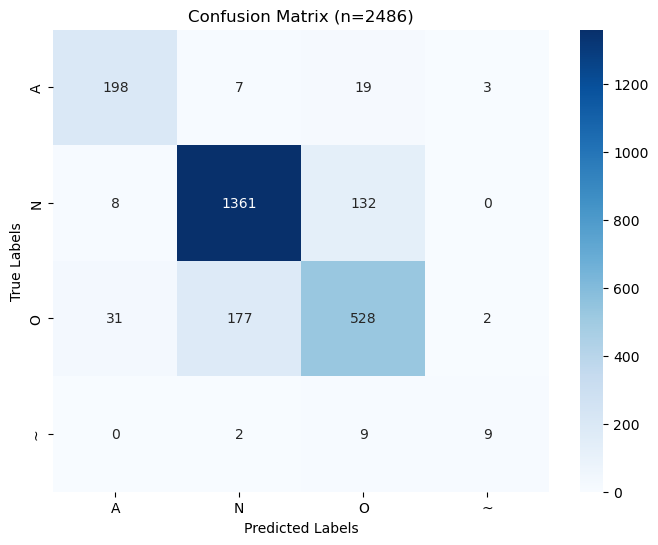

In [10]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])